In [18]:
#from pprint import pprint   # only for this example
import matplotlib.pyplot as plt
from agilent_ir_file import AgilentIRFile
import library_OS_fit as lib_OS
import spec_process as spec_p
import numpy as np
import agilent_to_python as a2p
from scipy import stats
import pandas as pd
from collections import Counter

In [19]:
filename = r'C:\Users\Shreyas.Patankar\Ocean Wise Conservation Association\Plastics Lab Team - General\00_FTIR_Data\mosaic_test_and_results\test20230424b\test20230424b.dmt'
reader = AgilentIRFile()
reader.read(filename)

xvalues = reader.wavenumbers
intensities = reader.intensities
metadata = reader.metadata

print(xvalues)
print(intensities.shape)
#pprint(metadata)
intensities = a2p.hsi_df(reader)
wavenumbers = a2p.data_wns(reader)

[ 898.66574955  900.59421682  902.5226841  ... 3897.43236017 3899.36082745
 3901.28929472]
(1152, 1152, 1558)


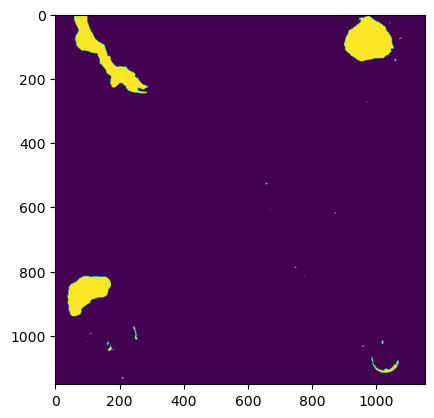

In [29]:
#from skimage import morphology, measure

from skimage.morphology import disk, closing, medial_axis, skeletonize
from skimage.measure import label, regionprops, regionprops_table

im = reader.total_image
mask = im > 5*im.mean()
#clsd = closing(mask,disk(20))
#fig, axs = plt.subplots(1,4,figsize=(20,15))
#axs[0].imshow(im)
#axs[1].imshow(mask)
#axs[2].imshow(clsd)
plt.imshow(mask)


In [30]:

lbls, ns = label(mask, return_num = True)
props = regionprops(lbls)


In [138]:
library_wavenos = lib_OS.get_lib_wns()

smoothing_order = 2
smoothing_window = 5

clust_der_values = pd.read_csv('OS_clusters_DERINT.csv')

def norm_pearson(p,q):
    modp = p/(np.max(p) - np.min(p))
    modq = q/(np.max(q) - np.min(q))
    return stats.pearsonr(modp,modq)[0]


def pearson_rs(p):
    def normp_pearson(q):
        return norm_pearson(p,q)
    return np.apply_along_axis(normp_pearson,axis=0,arr=clust_der_values)

def bPR(p):
    proc = spec_p.proc(p,smoothing_window, smoothing_order,wavenumbers,library_wavenos)
    prsc = pearson_rs(proc)
    ix = np.argmax(prsc)
    if prsc[ix] > 0.3:
        return (ix , prsc[ix])
    else: return (ix, prsc[ix])



In [61]:
lst = props[23].coords
#plt.plot([len(prop.coords) for prop in props],'o')
#plt.ylim([-10,1000])
len(lst)

841

In [95]:
elements = []

for coords in lst:
    row_index, column_index = coords
    spectrum = intensities[row_index, column_index]
    elements.append(bPR(spectrum))


In [96]:
from collections import Counter

def most_elements(input_list, majority_threshold=0.80):
    element_counts = Counter(input_list)  # Count occurrences of each element
    sorted_elements = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)  # Sort by abundance

    total_elements = len(input_list)
    majority_count = total_elements * majority_threshold

    selected_elements = []
    accumulated_count = 0

    for element, count in sorted_elements:
        accumulated_count += count
        selected_elements.append(element)

        if accumulated_count >= majority_count:
            break

    return selected_elements

# Example input list
data = [x[0] for x in elements]

# Select elements that account for the majority (at least 50% by abundance)
majority_elements = most_elements(data)

print("Selected majority elements:", [lib_OS.catID(k) for k in majority_elements])


Selected majority elements: ['unresolved polyethylene', 'PTFE']


[(14, 582), (6, 182), (2, 40), (1, 24), (17, 12), (12, 1)]

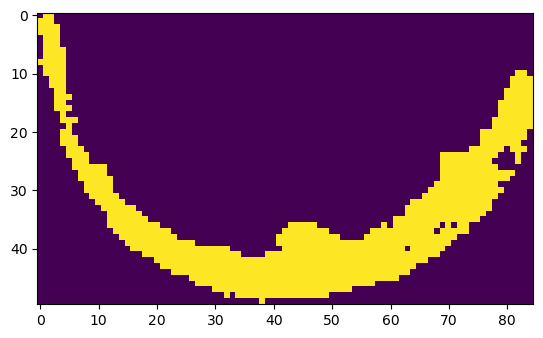

In [97]:
el_co = Counter([x[0] for x in elements if x[1] > 0.003])
plt.imshow(props[23].image)
sorted(el_co.items(), key=lambda x: x[1], reverse=True)
#lib_OS.catID(6)

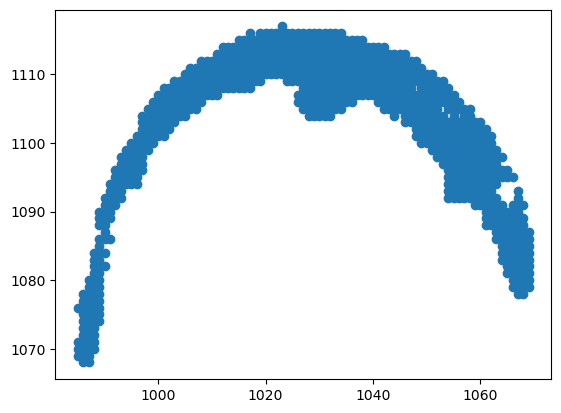

In [98]:
plt.plot(props[23].coords[:,1],props[23].coords[:,0],'o')


True
PTFE
(6, 0.20823356901931547)


,spectrum_identity,particle_ID,clust_ix,Pearson_Rs
223,PET,224,6,0.253827
225,PET,226,6,0.247176
222,PET,223,6,0.245406
224,PET,225,14,0.243543
70,HDPE,71,1,0.242662


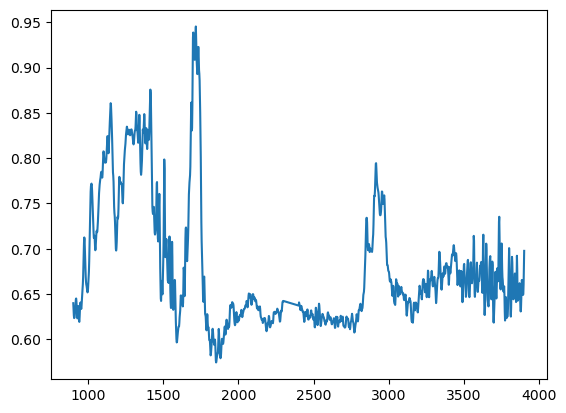

In [152]:
#plt.plot(spec_p.proc(intensities[1110,1030],smoothing_window, smoothing_order,wavenumbers,library_wavenos))
plt.plot(wavenumbers,intensities[1110,1030])
#plt.plot(spectrum)
#smoothing_window = 5
print([1110,1030] in lst)
print(lib_OS.catID(bPR(intensities[1110,1030])[0]))
print(bPR(intensities[1110,1030]))

#pearson_rs(spec_p.proc(intensities[1110,1030],smoothing_window, smoothing_order,wavenumbers,library_wavenos))
lib_OS.libOS_fit_1(spec_p.proc(intensities[1110,1030],smoothing_window, smoothing_order,wavenumbers,library_wavenos))

In [100]:

#len(props)
#axs[3].imshow(skeletonize(props[2].image))
#props[3].orientation

def appr_len(region):
    q = np.arctan(np.shape(region)[0]/np.shape(region)[1])
    return (np.sum(skeletonize(region)))*((np.sqrt(2)-1)*(np.sin(2*q)**2)+1)

def appr_wid(region):
    skel, distance = medial_axis(region, return_distance=True)
    return np.mean([2*k for k in distance.flatten() if k >= np.percentile(distance.flatten(),95)])

morph_table = pd.DataFrame(regionprops_table(lbls, properties = ['label','area','axis_major_length', 'axis_minor_length', 'solidity'], extra_properties = (appr_len,appr_wid,)))

appr_len = []
appr_wid = []

for ix in morph_table.index:
    if  morph_table.loc[ix,'solidity'] > 0.7:
        appr_len.append(morph_table.loc[ix,'axis_major_length'])
        appr_wid.append(morph_table.loc[ix,'axis_minor_length'])
    else:
        appr_len.append(morph_table.loc[ix,'appr_len'])
        appr_wid.append(morph_table.loc[ix,'appr_wid'])
    

morph_table['appr_len'] = appr_len
morph_table['appr_wid'] = appr_wid
morph_table = morph_table[['label','area','solidity','appr_len','appr_wid']]
morph_table

,label,area,solidity,appr_len,appr_wid
0,1,14249.0,0.598044,769.745300,36.694249
1,2,15073.0,0.945134,147.610309,132.772821
2,3,7.0,1.000000,4.000000,2.213133
3,4,19.0,0.791667,10.394164,2.309829
4,5,29.0,0.828571,8.580441,4.628691
5,6,1.0,1.000000,0.000000,0.000000
6,7,4.0,1.000000,2.000000,2.000000
7,8,19.0,0.950000,5.706236,4.175324
8,9,3.0,1.000000,2.309401,1.333333
9,10,11.0,0.846154,4.070110,3.501521
